# V6
## Hybrid + Edge Feature + Node Features

In [ ]:
!pip install torch torchvision torchaudio torch-geometric torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

import random
import time
import numpy as np
from sklearn.metrics import ndcg_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import torch
import torch.nn as nn
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
from torch_geometric.nn import GATConv
import torch.nn.functional as F
from google.colab import drive
from torch_geometric.nn import TransformerConv

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html


In [ ]:
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/ceng_msc/562/movielens/ml-100k/processed_data.csv'
full_data = pd.read_csv(data_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

full_data['user_id'] = user_encoder.fit_transform(full_data['user_id'])
full_data['movie_id'] = movie_encoder.fit_transform(full_data['movie_id'])

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
gender_mapping = {'M': 0, 'F': 1}
full_data['gender'] = full_data['gender'].map(gender_mapping)

occupation_encoder = LabelEncoder()
full_data['occupation'] = occupation_encoder.fit_transform(full_data['occupation'])

age_scaler = StandardScaler()
full_data['age'] = age_scaler.fit_transform(full_data[['age']])

year_scaler = StandardScaler()
full_data['release_year'] = year_scaler.fit_transform(full_data[['year']])
genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
                 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
                 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
genre_features = full_data[genre_columns].values

In [ ]:
num_users = full_data['user_id'].nunique()
num_movies = full_data['movie_id'].nunique()

full_data['movie_id'] += num_users

user_features = full_data[['user_id', 'age', 'gender']].drop_duplicates(subset=['user_id']).sort_values('user_id')
user_features = torch.tensor(user_features[['age', 'gender']].values, dtype=torch.float)

movie_features = full_data[['movie_id', 'release_year'] + genre_columns].drop_duplicates(subset=['movie_id']).sort_values('movie_id')
movie_features = torch.tensor(movie_features[['release_year'] + genre_columns].values, dtype=torch.float)

In [ ]:
print(f"User Features Shape: {user_features.shape}")
print(f"Movie Features Shape: {movie_features.shape}")

max_feature_dim = max(user_features.shape[1], movie_features.shape[1])

if user_features.shape[1] < max_feature_dim:
    padding = max_feature_dim - user_features.shape[1]
    user_features = F.pad(user_features, (0, padding))

if movie_features.shape[1] < max_feature_dim:
    padding = max_feature_dim - movie_features.shape[1]
    movie_features = F.pad(movie_features, (0, padding))

node_features = torch.cat([user_features, movie_features], dim=0)

print(f"Checking node_features for NaN or Inf...")
print(f"NaN in node_features: {torch.isnan(node_features).any()}")
print(f"Inf in node_features: {torch.isinf(node_features).any()}")

node_features = torch.nan_to_num(node_features, nan=0.0, posinf=1.0, neginf=-1.0)


User Features Shape: torch.Size([943, 2])
Movie Features Shape: torch.Size([1682, 20])
Checking node_features for NaN or Inf...
NaN in node_features: False
Inf in node_features: False


In [ ]:
from sklearn.model_selection import train_test_split

edges = full_data[['user_id', 'movie_id']].values
ratings = full_data['rating'].values

train_edges, test_edges, train_ratings, test_ratings = train_test_split(
    edges, ratings, test_size=0.2, random_state=42
)

train_edge_index = torch.tensor(train_edges.T, dtype=torch.long)
train_edge_attr = torch.tensor(train_ratings, dtype=torch.float)
test_edge_index = torch.tensor(test_edges.T, dtype=torch.long)
test_edge_attr = torch.tensor(test_ratings, dtype=torch.float)

train_data = Data(
    x=node_features,
    edge_index=train_edge_index,
    edge_attr=train_edge_attr
)
test_data = Data(
    x=node_features,
    edge_index=test_edge_index,
    edge_attr=test_edge_attr
)


In [ ]:
print("Max user ID in train_edges:", train_edges[:, 0].max())
print("Max user ID in test_edges:", test_edges[:, 0].max())
print("num_users:", num_users)

edges = full_data[['user_id', 'movie_id']].values
ratings = full_data['rating'].values


Max user ID in train_edges: 942
Max user ID in test_edges: 942
num_users: 943


In [ ]:
class LightGCN(nn.Module):
    def __init__(self, num_nodes, embedding_dim, num_layers=5):
        super().__init__()
        self.num_nodes = num_nodes
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embeddings = nn.Embedding(num_nodes, embedding_dim)
        nn.init.xavier_uniform_(self.embeddings.weight)

    def forward(self, data):
        edge_index = data.edge_index
        E0 = self.embeddings.weight
        all_embs = [E0]
        E_temp = E0
        for _ in range(self.num_layers):
            E_temp = self.propagate(edge_index, E_temp)
            all_embs.append(E_temp)
        E_final = torch.mean(torch.stack(all_embs, dim=0), dim=0)
        return E_final

    def propagate(self, edge_index, x):
        src, dst = edge_index
        out = torch.zeros_like(x)
        out.index_add_(0, dst, x[src])
        deg = torch.bincount(dst, minlength=x.size(0)).clamp(min=1)
        out = out / deg.unsqueeze(1)
        return out

In [ ]:
class EdgeAwareGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = TransformerConv(in_channels=input_dim,
                                     out_channels=hidden_dim,
                                     heads=4,
                                     dropout=0.3,
                                     edge_dim=1)

        self.conv2 = TransformerConv(in_channels=hidden_dim*4,
                                     out_channels=output_dim,
                                     heads=1,
                                     dropout=0.3,
                                     edge_dim=1)


        self.edge_predictor = nn.Linear(output_dim * 2, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        edge_attr = edge_attr.unsqueeze(-1)

        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)

        src = x[edge_index[0]]
        dst = x[edge_index[1]]
        edge_features = torch.cat([src, dst], dim=1)
        out = self.edge_predictor(edge_features)
        return out.squeeze()

In [ ]:
class HybridModel(nn.Module):
    def __init__(self,
                 num_nodes,
                 edge_input_dim,
                 gnn_hidden_dim,
                 gnn_output_dim,
                 lgn_embedding_dim,
                 lgn_layers,
                 num_users, num_movies):
        super().__init__()
        self.edge_aware_gnn = EdgeAwareGNN(input_dim=edge_input_dim,
                                           hidden_dim=gnn_hidden_dim,
                                           output_dim=gnn_output_dim)

        self.lightgcn = LightGCN(num_nodes, lgn_embedding_dim, num_layers=lgn_layers)

        self.user_bias = nn.Embedding(num_users, 1)
        self.item_bias = nn.Embedding(num_movies, 1)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

        combined_dim = gnn_output_dim + lgn_embedding_dim
        self.predictor = nn.Linear(combined_dim * 2, 1)

    def forward(self, data):
        edge_index, edge_attr = data.edge_index, data.edge_attr

        x_node = self._edge_aware_node_embeddings(data)

        x_lgcn = self.lightgcn(data)

        src = edge_index[0]
        dst = edge_index[1]

        user_aware = x_node[src]
        item_aware = x_node[dst]
        user_lgcn = x_lgcn[src]
        item_lgcn = x_lgcn[dst]

        user_combine = torch.cat([user_aware, user_lgcn], dim=1)
        item_combine = torch.cat([item_aware, item_lgcn], dim=1)

        edge_features = torch.cat([user_combine, item_combine], dim=1)
        rating_raw = self.predictor(edge_features).squeeze()

        u_bias = self.user_bias(src).squeeze()
        i_bias = self.item_bias(dst - num_users).squeeze()

        rating = rating_raw + u_bias + i_bias

        return rating

    def _edge_aware_node_embeddings(self, data):
        """
        A helper function to retrieve the node embeddings from EdgeAwareGNN
        after the second convolution, but BEFORE the final edge predictor.
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        edge_attr = edge_attr.unsqueeze(-1)

        x = self.edge_aware_gnn.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.edge_aware_gnn.conv2(x, edge_index, edge_attr=edge_attr)

        return x


In [ ]:
def train_with_timing():
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    predicted_ratings = model(train_data)
    loss = F.mse_loss(predicted_ratings, train_data.edge_attr)
    loss.backward()
    optimizer.step()
    train_time = time.time() - start_time
    return loss.item(), train_time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = node_features.shape[1]
hidden_dim = 128
output_dim = 32

model = HybridModel(
    num_nodes=(num_users + num_movies),
    edge_input_dim=node_features.shape[1],
    gnn_hidden_dim=256,
    gnn_output_dim=64,
    lgn_embedding_dim=128,
    lgn_layers=3,
    num_users=num_users,
    num_movies=num_movies
).to(device)

train_data = train_data.to(device)
test_data = test_data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
def evaluate_with_timing():
    start_time = time.time()
    model.eval()
    with torch.no_grad():
        predicted_ratings = model(test_data)
        predicted_ratings = torch.clamp(predicted_ratings, min=1.0, max=5.0)
        test_loss = F.mse_loss(predicted_ratings, test_data.edge_attr).item()
    inference_time = time.time() - start_time
    return test_loss, inference_time


In [ ]:
def compute_metrics(predicted_ratings, true_ratings):
    mse = mean_squared_error(true_ratings, predicted_ratings)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_ratings, predicted_ratings)

    within_half = (np.abs(true_ratings - predicted_ratings) <= 0.5).mean()
    success_rate = within_half * 100

    exact_matches = (true_ratings == predicted_ratings).mean() * 100

    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Success Rate (±0.5): {success_rate:.2f}%")
    print(f"Exact Match Rate: {exact_matches:.2f}%")

    return mse, rmse, mae, success_rate, exact_matches


In [ ]:
def precision_recall_with_interval(predictions, true_ratings, interval=0.5, threshold=3.0):
    differences = np.abs(predictions - true_ratings)
    predicted_relevant = differences <= interval

    true_relevant = true_ratings >= threshold

    tp = np.sum(predicted_relevant & true_relevant)
    fp = np.sum(predicted_relevant & ~true_relevant)
    fn = np.sum(~predicted_relevant & true_relevant)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return precision, recall

In [ ]:
def plot_loss(training_losses, testing_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(range(0, len(testing_losses) * 10, 10), testing_losses, label='Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.show()

In [ ]:
def plot_true_vs_predicted(true_ratings, predicted_ratings):
    plt.figure(figsize=(8, 6))
    plt.scatter(true_ratings, predicted_ratings, alpha=0.5, label='Predictions')
    plt.plot([1, 5], [1, 5], color='red', linestyle='--', label='Ideal Predictions')
    plt.xlim(0.8, 5.2)
    plt.ylim(0.8, 5.2)
    plt.xticks(range(1, 6))
    plt.yticks(range(1, 6))
    plt.title('True Ratings vs Predicted Ratings')
    plt.xlabel('True Ratings')
    plt.ylabel('Predicted Ratings')
    plt.legend()
    plt.show()


In [ ]:
training_losses = []
testing_losses = []
training_times = []

best_test_loss = float('inf')
patience_limit = 20
patience_counter = 0

max_epochs = 500

for epoch in range(max_epochs):
    loss, train_time = train_with_timing()
    training_losses.append(loss)
    training_times.append(train_time)

    if epoch % 10 == 0:
        test_loss, inference_time = evaluate_with_timing()
        testing_losses.append(test_loss)
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Training Time: {train_time:.4f}s, Inference Time: {inference_time:.4f}s")
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience_limit:
            print(f"Early stopping at epoch {epoch}, best test loss: {best_test_loss:.4f}")
            break

Epoch 0, Loss: 12.1722, Test Loss: 2.4116, Training Time: 0.0215s, Inference Time: 0.0048s
Epoch 10, Loss: 2.3861, Test Loss: 2.3715, Training Time: 0.0177s, Inference Time: 0.0043s
Epoch 20, Loss: 1.5024, Test Loss: 1.1292, Training Time: 0.0167s, Inference Time: 0.0042s
Epoch 30, Loss: 1.1103, Test Loss: 0.9377, Training Time: 0.0165s, Inference Time: 0.0042s
Epoch 40, Loss: 1.0426, Test Loss: 0.9474, Training Time: 0.0165s, Inference Time: 0.0042s
Epoch 50, Loss: 1.0416, Test Loss: 0.9300, Training Time: 0.0170s, Inference Time: 0.0043s
Epoch 60, Loss: 1.0036, Test Loss: 0.9008, Training Time: 0.0165s, Inference Time: 0.0042s
Epoch 70, Loss: 0.9846, Test Loss: 0.8878, Training Time: 0.0165s, Inference Time: 0.0043s
Epoch 80, Loss: 0.9600, Test Loss: 0.8679, Training Time: 0.0165s, Inference Time: 0.0042s
Epoch 90, Loss: 0.9360, Test Loss: 0.8525, Training Time: 0.0166s, Inference Time: 0.0042s
Epoch 100, Loss: 0.9204, Test Loss: 0.8379, Training Time: 0.0165s, Inference Time: 0.0042

In [ ]:
inference_times = []
for epoch in range(0, 500, 10):
    _, inference_time = evaluate_with_timing()
    inference_times.append(inference_time)

average_training_time = np.mean(training_times)
average_inference_time = np.mean(inference_times)

print("\nSummary of Training and Evaluation Times:")
print(f"  - Average Training Time per Epoch: {average_training_time:.4f}s")
print(f"  - Average Inference Time: {average_inference_time:.4f}s")


Summary of Training and Evaluation Times:
  - Average Training Time per Epoch: 0.0168s
  - Average Inference Time: 0.0039s


In [ ]:
model.eval()
with torch.no_grad():
    predicted_ratings = model(test_data)
    raw_predictions = predicted_ratings.cpu().numpy()
    predicted_ratings = np.clip(raw_predictions, 1.0, 5.0)
    true_ratings = test_data.edge_attr.cpu().numpy()

In [ ]:
mse, rmse, mae, success_rate, exact_matches = compute_metrics(predicted_ratings, true_ratings)

precision, recall = precision_recall_with_interval(predicted_ratings, true_ratings, interval=0.5)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

ndcg = ndcg_score([true_ratings], [predicted_ratings])
print(f"NDCG: {ndcg:.4f}")

MSE: 0.8178
RMSE: 0.9043
MAE: 0.7090
Success Rate (±0.5): 43.29%
Exact Match Rate: 0.82%
Precision: 0.9317
Recall: 0.4880
NDCG: 0.9885


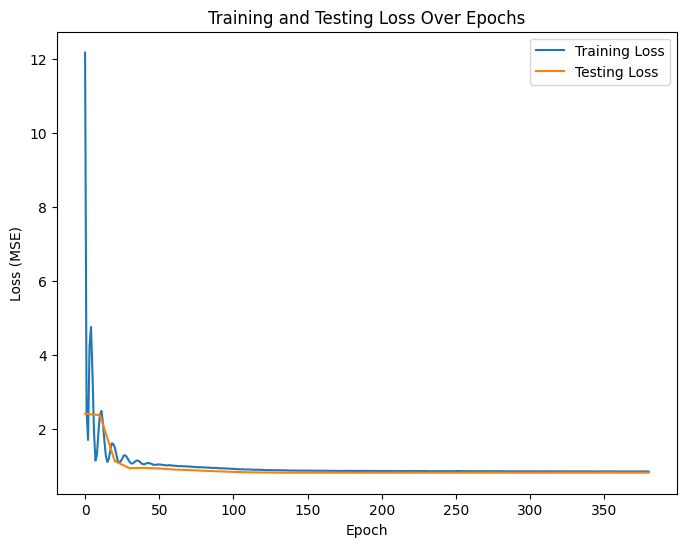

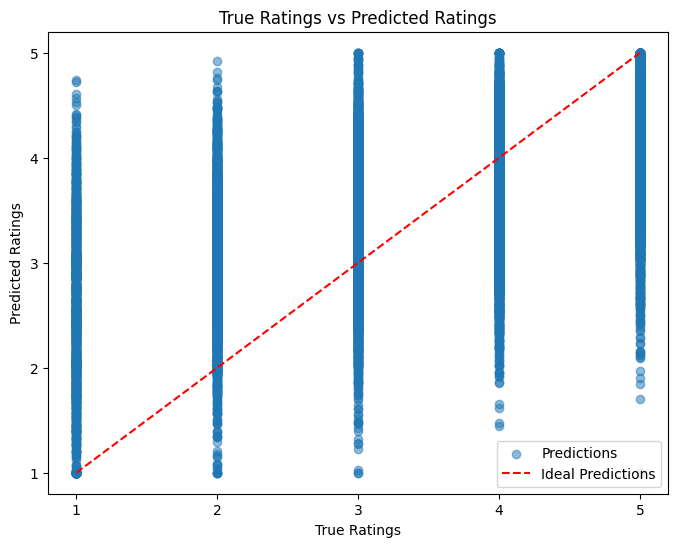

In [ ]:
plot_loss(training_losses, testing_losses)
plot_true_vs_predicted(true_ratings, predicted_ratings)